In [200]:
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedShuffleSplit 
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import re, string, timeit
import pickle
import math
from textblob import TextBlob 
import string
import re
from nltk.corpus import stopwords
from stemming.porter2 import stem
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedShuffleSplit 
from sklearn import preprocessing, metrics
get_ipython().magic('matplotlib inline')
#pd.set_option('max_colwidth', 10000)

In [202]:
jd_train = pd.read_csv('/Users/chidam/data_sci/data/capstone/train_df.csv')
#jd_train = pd.read_csv("/Users/prate/Documents/Python Scripts/ziprec_train_refined.csv")
#jd_train.drop('Unnamed: 0',axis=1,inplace=True)
jd_train.columns

Index(['job_url', 'company', 'title', 'location', 'desc', 'target'], dtype='object')

In [203]:

print(jd_train.head())
jd_train.info()
jd_train.fillna('XYZ',inplace=True)
jd_train[jd_train['company'].isnull()]


                                             job_url             company  \
0  https://www.ziprecruiter.com/clk/verticalmove-...  verticalmove, inc.   
1  https://www.ziprecruiter.com/clk/elite-technic...     elite technical   
2  https://www.ziprecruiter.com/clk/cgi-236f5679-...                 cgi   
3  https://www.ziprecruiter.com/clk/my-headhunter...   my headhunter llc   
4  https://www.ziprecruiter.com/clk/prokarma-inc-...      prokarma, inc.   

                                               title           location  \
0  lead/sr data scientist - legal analytics - big...  san francisco, ca   
1       data scientist (big data) in washington , dc     washington, dc   
2                                     data scientist        fairfax, va   
3                       data scientist (credit card)  san francisco, ca   
4                  bi data engineer (data scientist)       new york, ny   

                                                desc          target  
0  client  introducti

,job_url,company,title,location,desc,target


In [204]:
lbl_enc = preprocessing.LabelEncoder()

In [205]:
stop_words = set(stopwords.words("english"))
def bag_of_words(dictionary_with_count,dictionary_ref,dict_ref_src,dict_imed_prev, document, index):
    words = word_tokenize(document)
    for w in words:
        if w not in stop_words:
            if w not in dictionary_with_count:
                dictionary_with_count[w] = 1
                dictionary_ref[(index,w)] = 1
                dict_ref_src[w] = index
                dict_imed_prev[w] = index
            else:
                dictionary_with_count[w] += 1
                temp_index = dict_ref_src[w]
                if dict_imed_prev[w] != index:
                    dictionary_ref[(temp_index,w)] += 1
                    dict_imed_prev[w] = index
    return dictionary_with_count , dictionary_ref, dict_ref_src , dict_imed_prev
exclude = set(string.punctuation) - {'#'}
exclude = list(exclude)
exclude = exclude+['•']


In [206]:
def remove_punct(str1):
    exclude = set(string.punctuation) - {'#'}
    exclude = list(exclude)
    exclude = exclude+['•']
    for ch in exclude:
        str1 = str1.replace(ch,' ')        
    return(str1)

In [207]:
print(jd_train.head())

                                             job_url             company  \
0  https://www.ziprecruiter.com/clk/verticalmove-...  verticalmove, inc.   
1  https://www.ziprecruiter.com/clk/elite-technic...     elite technical   
2  https://www.ziprecruiter.com/clk/cgi-236f5679-...                 cgi   
3  https://www.ziprecruiter.com/clk/my-headhunter...   my headhunter llc   
4  https://www.ziprecruiter.com/clk/prokarma-inc-...      prokarma, inc.   

                                               title           location  \
0  lead/sr data scientist - legal analytics - big...  san francisco, ca   
1       data scientist (big data) in washington , dc     washington, dc   
2                                     data scientist        fairfax, va   
3                       data scientist (credit card)  san francisco, ca   
4                  bi data engineer (data scientist)       new york, ny   

                                                desc          target  
0  client  introducti

In [208]:

jd_desc = jd_train.desc

#print(jd_train.desc)
dict_jd_desc={}
dictionary_ref={}
dict_ref_src={}
dict_imed_prev = {}
for index, i in enumerate(jd_desc, start = 0):
#   print("Processing {}, {}...".format(index, i))
    #.append(remove_punct(str(course_names[index].lower())))
    dict_jd_desc , dictionary_ref, dict_ref_src, dict_imed_prev = bag_of_words(dict_jd_desc, dictionary_ref, dict_ref_src,dict_imed_prev,remove_punct(jd_desc[index].lower()),index)
#print(dict_jd_desc)

In [209]:
print(remove_punct(jd_desc[0].lower()))

client  introduction lead or senior data scientist to join our rapidly growing team  as a senior member of the data science team  you will design systems to tackle tough problems in the legal domain and expand our award winning products   we were launched from stanford university s law school  computer science department  and with the support of codex  stanford s center for legal informatics   we have been featured in wired  the new york times  the american bar association journal  and our founder is a forbes 30 under 30 for 2015   series a startup funded by top tier investors like nea  our culture is extremely dog  and human friendly  our office headquarters are in san francisco  south of market   conveniently located between bart and caltrain   job  description job  responsibilities   define and optimize named entity recognition  ner  for entity types including  citations  courts  judges  parties  motions  outcomes  law firms  and companies     semantic relatedness     topic modellin

In [210]:
print(len(dict_jd_desc))
jd_desc_top_words = []
jd_desc_top_words = sorted(dict_jd_desc.items(), key=lambda dict_jd_desc:-dict_jd_desc[1])
#print(jd_desc_top_words)

37262


In [211]:
jd_desc_top_words_list=[]
for k in jd_desc_top_words:
    jd_desc_top_words_list.append(k[0])
#print(jd_desc_top_words_list)

In [212]:
print(len(jd_desc_top_words_list))

37262


In [213]:
#tfidf
desc_list=[]
tfidf_final_dict = {}
#for i in jd_train.desc:
for i in jd_desc:
    desc_list.append(TextBlob(remove_punct(str(i).lower())))
    #desc_list.append(TextBlob(i))
type(desc_list)

count = 0
for i, blob in enumerate(desc_list):
    #print("\nTop TF-IDFs for Description", i+1)
    #print(i)
    
    tfidf = {}
    
    for term in blob.words:
        if term not in stop_words:
            count += 1
            # Term Frequency (TF) in doc:
            #     Number of times a term appears in a document, 
            #     normalized by dividing by the total number of terms in the document
            tf = blob.words.count(term) / len(blob.words)
            nd = len(desc_list)
            # number of documents with term
            #ndwt = sum(1 for b in desc_list if term in b)
            ndwt = dictionary_ref[(dict_ref_src[term],term)]
            #print(nd)
            # Inverse Document Frequency (IDF)
            #     Measures how common a term is among all documents. 
            #     The more common a term is, the lower its IDF. 
            #     Take the log of the ratio of the total number of documents to 
            #     the number of documents containing the term. 
            #     Add 1 to the divisor to prevent division by zero.
            idf = math.log(nd/(1+ndwt))

            # TFIDF = TF*IDF 
            # Intuitively:
            # If a term appears frequently in a document, it's important - give the term a high score.
            # But if a term appears in many documents, it's not a unique identifier - give the term a low score.
            if round(tf*idf, 5) >= 0.02 and (not term.isdigit()) and term != 'target':
                tfidf[term] = round(tf*idf, 5)
    
    # sort terms in document by TFIDF
    tfidf_final_dict[i] = dict(sorted(tfidf.items(), key=lambda x: x[1], reverse=True))
    #print(tfidf)
    

In [157]:
#print(desc_list[2])
print(tfidf_final_dict)

{0: {'exposure': 0.0221, 'stanford': 0.03872, 'linguists': 0.02164, 'powered': 0.03725, 'mallet': 0.02164, 'law': 0.02309, 'judges': 0.02164, 'h2o': 0.0203, 'helpful': 0.02524, 'factorie': 0.02164, 'dog': 0.02164, 'ner': 0.02164, 'stanfordnlp': 0.02164, 'citations': 0.02164, 'relatedness': 0.02164, 'meetups': 0.0203, 'legal': 0.04039, 'codex': 0.02164, 'lda': 0.0203, 'word2vec': 0.02164, 'annotation': 0.02164, 'nea': 0.02164, 'courts': 0.02164, 'motions': 0.02164, 'conveniently': 0.0203, 'entity': 0.03096, 'crf': 0.0203, 'caltrain': 0.02164, 'complexities': 0.0203, 'topic': 0.0203, 'domain': 0.03239}, 1: {'open': 0.02099, 'metropolitan': 0.0293, 'prediction': 0.02343, 'dhs': 0.03147, 'dc': 0.03159, 'dod': 0.02517}, 2: {'cgi': 0.07739}, 3: {'card': 0.02711, 'digital': 0.04136, 'acquisition': 0.03127, 'incubator': 0.03645, 'credit': 0.02194}, 4: {'assortment': 0.04101, 'backchaining': 0.02151, 'recommendation': 0.0627, 'rankings': 0.02151, 'fedback': 0.02151, 'selling': 0.02913, 'choice'

In [214]:
tfidf_final_dict_comp = {}
for i in tfidf_final_dict.keys():
    for j in tfidf_final_dict[i].keys():
        tfidf_final_dict_comp[j] = 1
    
print(len(tfidf_final_dict_comp))     
for col in tfidf_final_dict_comp:
    jd_train[col] = 0

21775


In [215]:
for index, i in enumerate(jd_train.title,start = 0):
    resume_desc_list = []
    jd_train[col] = 0
    print("Processing {}, {}...".format(index, i))
    if len(list(tfidf_final_dict[index].keys())) > 1:
        jd_train.ix[index,list(tfidf_final_dict[index].keys())] = list(tfidf_final_dict[index].values())
    else:
        if len(list(tfidf_final_dict[index].keys())) == 1:
            for j,k in tfidf_final_dict[index].items():
                jd_train.ix[index,j] = k
    
        

Processing 0, 0...
Processing 1, 0...
Processing 2, 0...
Processing 3, 0...
Processing 4, 0...
Processing 5, 0...
Processing 6, 0...
Processing 7, 0...
Processing 8, 0...
Processing 9, 0...
Processing 10, 0...
Processing 11, 0...
Processing 12, 0...
Processing 13, 0...
Processing 14, 0...
Processing 15, 0...
Processing 16, 0...
Processing 17, 0...
Processing 18, 0...
Processing 19, 0...
Processing 20, 0...
Processing 21, 0...
Processing 22, 0...
Processing 23, 0...
Processing 24, 0...
Processing 25, 0...
Processing 26, 0...
Processing 27, 0...
Processing 28, 0...
Processing 29, 0...
Processing 30, 0...
Processing 31, 0...
Processing 32, 0...
Processing 33, 0...
Processing 34, 0...
Processing 35, 0...
Processing 36, 0...
Processing 37, 0...
Processing 38, 0...
Processing 39, 0...
Processing 40, 0...
Processing 41, 0...
Processing 42, 0...
Processing 43, 0...
Processing 44, 0...
Processing 45, 0...
Processing 46, 0...
Processing 47, 0...
Processing 48, 0...
Processing 49, 0...
Processing

In [216]:
jd_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 0 to 9018
Columns: 21777 entries, job_url to skyhigh
dtypes: float64(21774), int64(1), object(2)
memory usage: 1.5+ GB


In [217]:
jd_train['cgi'].head()
print(jd_train.columns)

Index(['job_url', 'company', 'title', 'location', 'desc', 'target', 'trane',
       'capacities', 'pluto', 'perceptual',
       ...
       'obi', 'maitreya', 'pertain', 'liquidity', 'fiserv',
       'processesperforming', 'gram', 'deseq2', 'memos', 'skyhigh'],
      dtype='object', length=21777)


In [218]:
jd_train.head()

,job_url,company,title,location,desc,target,trane,capacities,pluto,perceptual,...,obi,maitreya,pertain,liquidity,fiserv,processesperforming,gram,deseq2,memos,skyhigh
0,https://www.ziprecruiter.com/clk/verticalmove-...,0,0,0,0,data scientist,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.ziprecruiter.com/clk/elite-technic...,0,0,0,0,data scientist,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.ziprecruiter.com/clk/cgi-236f5679-...,0,0,0,0,data scientist,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://www.ziprecruiter.com/clk/my-headhunter...,0,0,0,0,data scientist,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,https://www.ziprecruiter.com/clk/prokarma-inc-...,0,0,0,0,data scientist,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
jd_train.to_csv('/Users/chidam/data_sci/data/capstone/train_final_zip_simply_df',index=False)

In [220]:
jd_train.drop(['job_url', 'company', 'title', 'location', 'desc'], axis = 1, inplace=True)

In [221]:
jd_target=jd_train.target
jd_train.drop('target',axis=1,inplace=True)

In [237]:
cols = jd_train.columns
cols_to_be_dropped = []
for i in cols:
    #print(jd_train[i].value_counts())
    if jd_train[i].value_counts()[0] >= 9000 and i != 'target':
        cols_to_be_dropped.append(i)
        

print(cols_to_be_dropped)

['trane', 'capacities', 'pluto', 'perceptual', '110k', 'notified', 'dark', 'segment', 'fragrances', 'mailto', 'exploitation', 'dynamical', 'oam', 'beliefs', 'marvell', 'appraisal', 'shooting', 'dashboardswhat', 'harmony', 'managementbusiness', 'qsi', 'visitingã', 'ccna', 'instrument’s', 'piloting', 'ben', 'henry', 'traveling', 'stallion', 'clg', 'weapon', 'fitting', 'universe', 'tracer', 'distinct', 'arimo', 'refuse', 'bioavailability', 'securing', 'reportswhat', 'generally', 'say', 'openlayers', 'sped', 'yen', 'selling', 'elevated', 'strive', 'ceus', 'ict', 'usjobscognizant', 'erdas', 'arch', 'wrangler', 'subscribe', 'an�systems', 'participations', 'convenient', 'solutionsinc', 'wilshire', 'pegasystems', 'imagery', 'poorly', 'confinements', 'trta', 'rescind', 'pimasc', 'xref', 'epicenter', 'ludlow', 'cracker', 'artful', 'solera', 'comprehensively', 'postdoctoral', 'anaslyst', 'burleson', 'kids', 'thresholds', 'hybrid', 'spot', 'gaming', 'narrative', 'stamford', 'cardfinancial', 'north

In [252]:
cols_pending= jd_train.columns
print(set(cols_pending) - set(cols))

set()


In [239]:
jd_train.drop(cols_to_be_dropped,axis=1,inplace=True)
print(jd_train.info())
print(jd_train.head())

ValueError: labels ['trane' 'capacities' 'pluto' ..., 'deseq2' 'memos' 'skyhigh'] not contained in axis

In [253]:
lbl_enc = preprocessing.LabelEncoder()

labels = jd_target.values
labels = lbl_enc.fit_transform(labels)
train, test,target_set, testing_target_set = train_test_split(jd_train,labels, test_size=0.25)

#target_set = train[['target']].values
#testing_target_set = test[['target']].values

forest = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=100)
forest = forest.fit(train, target_set)
print(forest.score(test, testing_target_set))
prob = forest.predict_proba(test)


0.527716186253


In [254]:
(pd.Series(labels)).value_counts()
print(prob)


[[ 0.398309    0.29452507  0.09453144  0.21263449]
 [ 0.75531236  0.09510279  0.02032024  0.12926461]
 [ 0.32616278  0.46849268  0.03161573  0.17372881]
 ..., 
 [ 0.01963384  0.01964332  0.24618938  0.71453346]
 [ 0.66859385  0.17876936  0.05480265  0.09783414]
 [ 0.16807592  0.81222052  0.01446745  0.00523611]]


Feature ranking:
1. feature 43 (0.027258)
2. feature 821 (0.016742)
3. feature 632 (0.012538)
4. feature 339 (0.011687)
5. feature 474 (0.010272)
6. feature 759 (0.008708)
7. feature 222 (0.008521)
8. feature 683 (0.008078)
9. feature 347 (0.007380)
10. feature 387 (0.006334)
11. feature 438 (0.006144)
12. feature 448 (0.005527)
13. feature 358 (0.004926)
14. feature 471 (0.004695)
15. feature 495 (0.004688)
16. feature 611 (0.004683)
17. feature 549 (0.004670)
18. feature 567 (0.004655)
19. feature 1 (0.004579)
20. feature 179 (0.004292)
21. feature 835 (0.004225)
22. feature 906 (0.004090)
23. feature 816 (0.003923)
24. feature 53 (0.003901)
25. feature 801 (0.003846)
26. feature 66 (0.003778)
27. feature 914 (0.003757)
28. feature 802 (0.003729)
29. feature 990 (0.003721)
30. feature 122 (0.003638)
31. feature 426 (0.003612)
32. feature 869 (0.003579)
33. feature 566 (0.003486)
34. feature 797 (0.003441)
35. feature 941 (0.003373)
36. feature 680 (0.003294)
37. feature 357 (0.003273

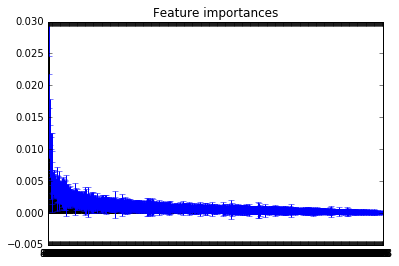

In [255]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

In [223]:
jd_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 0 to 9018
Columns: 21771 entries, trane to skyhigh
dtypes: float64(21770), int64(1)
memory usage: 1.5 GB


In [234]:
cols = jd_train.columns
cols_to_be_dropped = []
for i in cols:
    #print(jd_train[i].value_counts())
    if jd_train[i].value_counts()[0] >= 9000:
        cols_to_be_dropped.append(i)
        

print(cols_to_be_dropped)

['trane', 'capacities', 'pluto', 'perceptual', '110k', 'notified', 'dark', 'segment', 'fragrances', 'mailto', 'exploitation', 'dynamical', 'oam', 'beliefs', 'marvell', 'appraisal', 'shooting', 'dashboardswhat', 'harmony', 'managementbusiness', 'qsi', 'visitingã', 'ccna', 'instrument’s', 'piloting', 'ben', 'henry', 'traveling', 'stallion', 'clg', 'weapon', 'fitting', 'universe', 'tracer', 'distinct', 'arimo', 'refuse', 'bioavailability', 'securing', 'reportswhat', 'generally', 'say', 'openlayers', 'sped', 'yen', 'selling', 'elevated', 'strive', 'ceus', 'ict', 'usjobscognizant', 'erdas', 'arch', 'wrangler', 'subscribe', 'an�systems', 'participations', 'convenient', 'solutionsinc', 'wilshire', 'pegasystems', 'imagery', 'poorly', 'confinements', 'trta', 'rescind', 'pimasc', 'xref', 'epicenter', 'ludlow', 'cracker', 'artful', 'solera', 'comprehensively', 'postdoctoral', 'anaslyst', 'burleson', 'kids', 'thresholds', 'hybrid', 'spot', 'gaming', 'narrative', 'stamford', 'cardfinancial', 'north

In [235]:
print(len(cols_to_be_dropped))

20727


In [257]:
jd_train_final = pd.concat([pd.DataFrame(jd_target), jd_train],axis =1)
print(jd_train_final.info())
print(jd_train_final.head())
jd_train_final.to_csv('/Users/chidam/data_sci/data/capstone/train_final_full_sel_cols_df.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 0 to 9018
Columns: 1045 entries, target to vlookups
dtypes: float64(1044), object(1)
memory usage: 72.0+ MB
None
           target  pharmaceutical  predictive  provides  source  web  \
0  data scientist               0           0         0       0    0   
1  data scientist               0           0         0       0    0   
2  data scientist               0           0         0       0    0   
3  data scientist               0           0         0       0    0   
4  data scientist               0           0         0       0    0   

   functionality  stable  future  audits    ...     trading  central  logical  \
0              0       0       0       0    ...           0        0        0   
1              0       0       0       0    ...           0        0        0   
2              0       0       0       0    ...           0        0        0   
3              0       0       0       0    ...           0       

In [259]:
with open('model_forest_classification.pickle', 'wb') as handle:
  pickle.dump(forest, handle)

In [265]:
feature_dict = {}
feature_dict = dict((k,1) for k in list(jd_train_final.columns) )
#dict((k,2) for k in a)

In [268]:
with open('feature_dict.pickle', 'wb') as handle:
  pickle.dump(feature_dict, handle)